In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd ..

/home/naomichi/repos/src/github.com/agatan/ocr-experiments


In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from ocr.preprocessing.generator import CSVGenerator
from ocr.models import resnet50, bboxnet, mobilenet
from ocr.data import process

In [5]:
tf.keras.backend.set_session(tf.InteractiveSession())
backbone, features_pixel = mobilenet.backbone(input_shape=(512, 832, 3))
training_model, prediction_model = bboxnet.create_model(backbone, features_pixel, input_shape=(512, 832, 3), n_vocab=process.vocab())
tf.keras.backend.get_session().run(tf.global_variables_initializer())
training_model.load_weights('./checkpoint-weights.h5', by_name=True)
# prediction_model.get_weights()

In [6]:
gen = CSVGenerator('./data/processed/validation/annotations.csv', features_pixel=features_pixel, input_size=(512, 832), aug=True)
# gen = CSVGenerator('./data/processed/train/annotations.csv', features_pixel=features_pixel, input_size=(512, 832))
prediction_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 512, 832, 3)  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64, 104, 256) 3907264     image[0][0]                      
__________________________________________________________________________________________________
bbox (Conv2D)                   (None, 64, 104, 6)   1542        model[1][0]                      
__________________________________________________________________________________________________
confidence (Lambda)             (None, 64, 104)      0           bbox[0][0]                       
__________________________________________________________________________________________________
box (Lambd

In [7]:
x, y = next(gen.batches(batch_size=4))
images = x[0]
boxes, text = prediction_model.predict(images)

540169
64643
165493
71269387
3138
84862
527913
09
2943


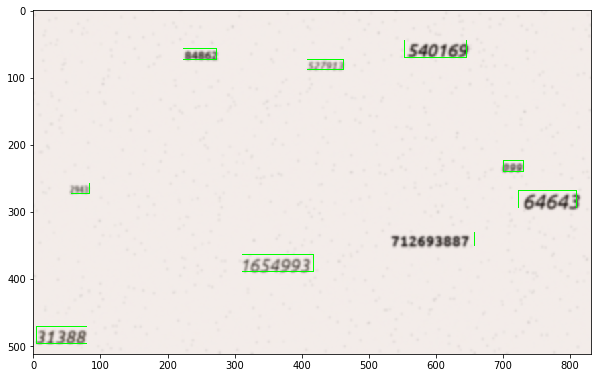

7342
8671
21070384
20127
561403
984
01054028


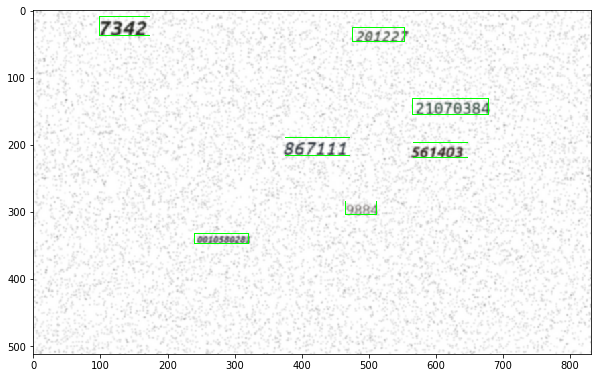

7316762
745
0717457
2698045237
45958
34127
807342986
019145074
86303479


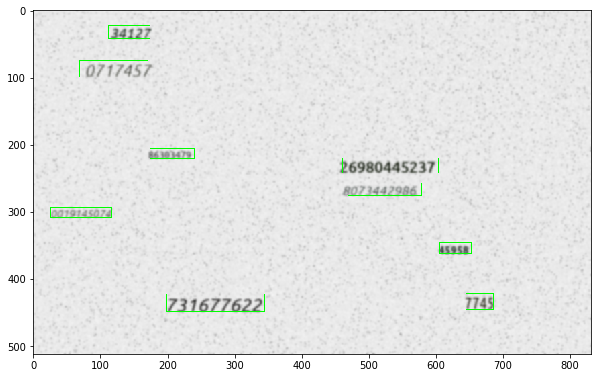

902
842039
347203
314
91076
303


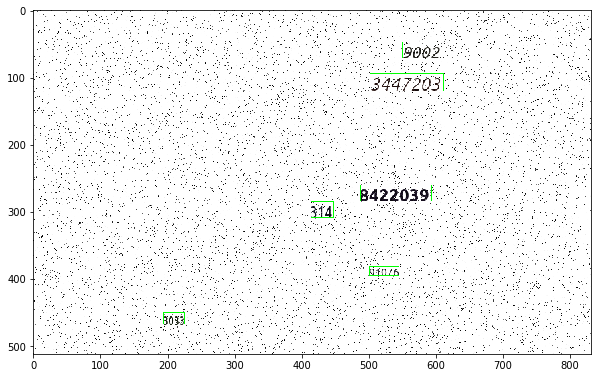

In [8]:
import random
import cv2
import math
import numpy as np
from itertools import groupby

images = x[0]

for i in range(len(images)):
    i_boxes = boxes[i]
    i_text = text[i]
    for ts in i_text:
        decoded = []
        for t in ts:
            if t == -1:
                break
            decoded.append(process.idx2char(t))
        if decoded:
            print(''.join(decoded))
    target = (images[i].copy() * 255).astype(np.int32)

    for (l, t, r, b) in i_boxes:
        cv2.rectangle(target, (l, t), (r, b), (0, 255, 0))

    plt.figure(figsize=(10, 10))
    plt.imshow(target)
    plt.show()

In [9]:
import time
start = time.time()
boxes, text = prediction_model.predict(images[0:1])
print(boxes.shape, text.shape)
print(time.time() - start)

(1, 32, 4) (1, 32, 46)
0.06992220878601074
